# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical
#from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD
import time
import xgboost

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import torch
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

#pd.set_option('display.max_rows', None)
#print('libraries imported!')

print('libraries imported!')

TensorFlow version: 2.12.0
Num GPUs Available:  1
libraries imported!


## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


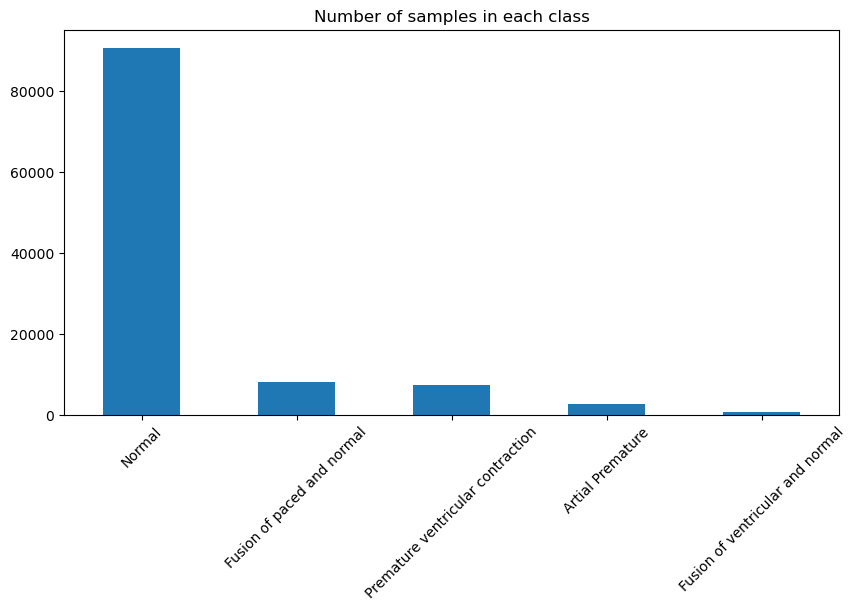

In [2]:
df_mitbih_train = pd.read_csv("mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

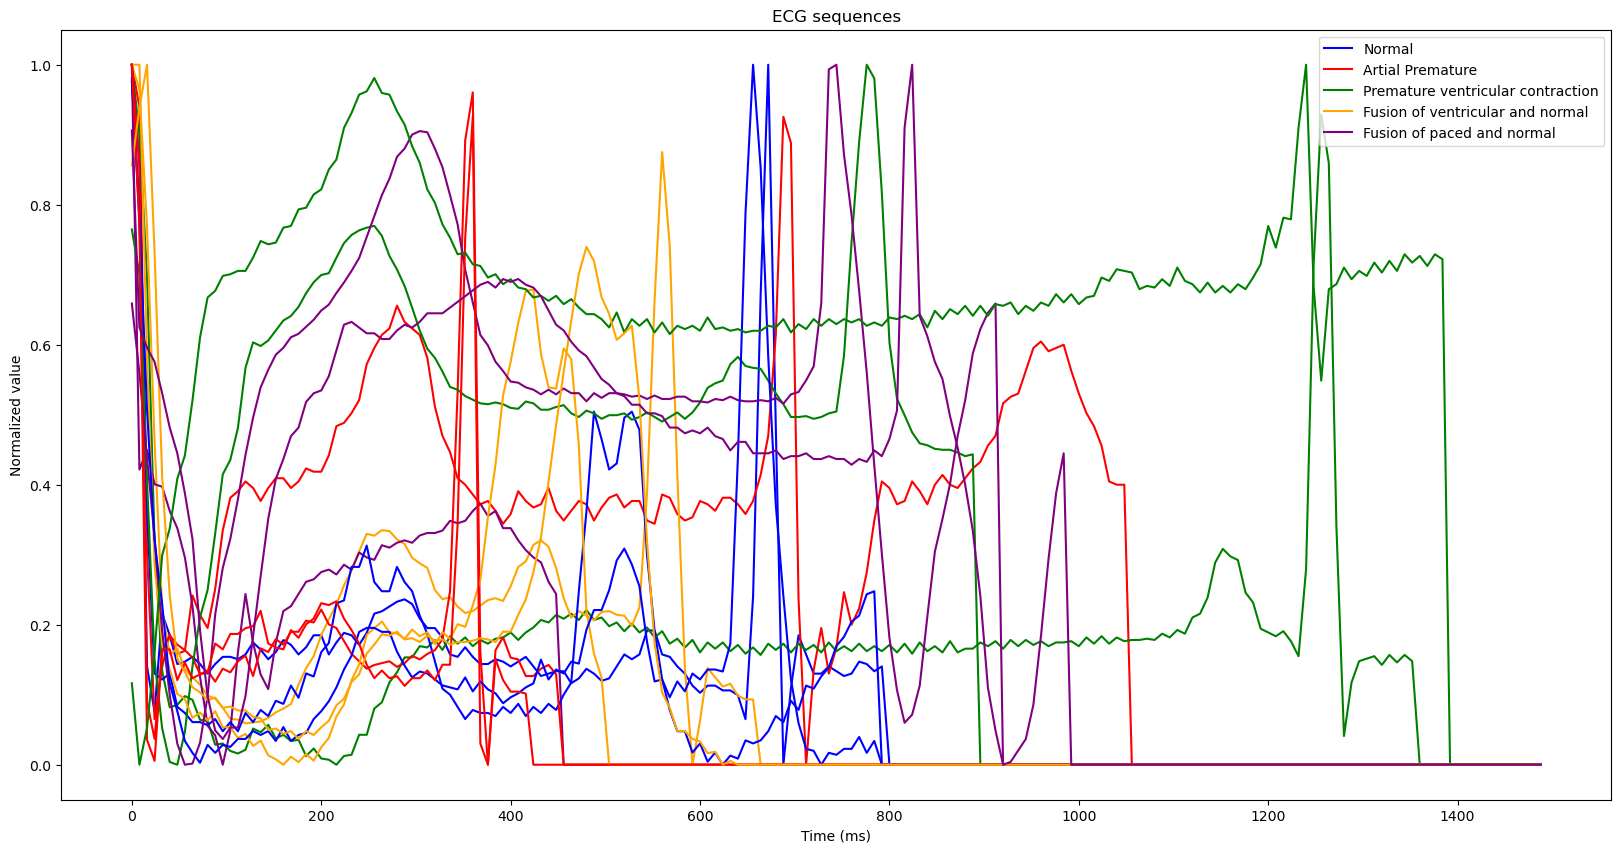

In [3]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [4]:
Y,X = np.array(df_mitbih['label']),np.array(df_mitbih.drop('label',axis=1))
Y = np.reshape(Y,(Y.shape[0],1))
Y = to_categorical(Y, num_classes=5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

   label    set  count
0      0   test  18160
1      0  train  72429
2      1   test    535
3      1  train   2244
4      2   test   1402
5      2  train   5834
6      3   test    158
7      3  train    645
8      4   test   1635
9      4  train   6404


Text(0, 0.5, 'Number of samples')

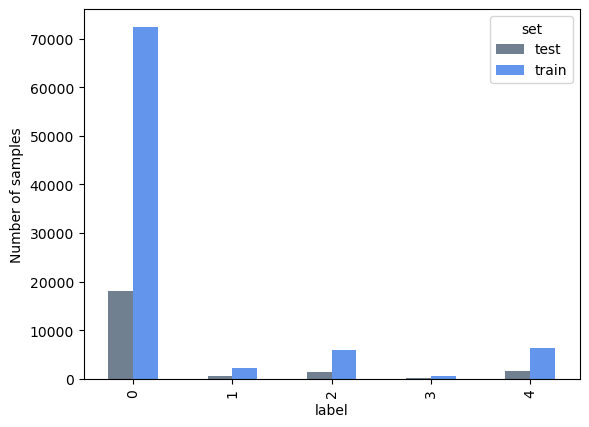

In [5]:
pd_ytrain = pd.DataFrame(np.argmax(Y_train,axis=1),columns=['label'])
pd_ytrain['set'] = 'train'

pd_ytest = pd.DataFrame(np.argmax(Y_test,axis=1),columns=['label'])
pd_ytest['set'] = 'test'

pd_y = pd.concat((pd_ytrain,pd_ytest),axis=0)
pd_y['int_label'] = pd_y['label'].astype(int)
pivot_y = pd.pivot_table(pd_y,values='int_label',index='set',aggfunc='count',columns='label')
pivot_y_df = pivot_y.reset_index()

grouped_data = pd_y.groupby(['label', 'set']).size().reset_index(name='count')
print(grouped_data)
pivot_data = grouped_data.pivot(index='label', columns='set', values='count')
pivot_data.plot.bar(stacked=False,color=['slategray','cornflowerblue'])
plt.ylabel('Number of samples')

### Decision Tree Classifiers

In [6]:
import time
def decision_tree_classifier(X_train,X_test,Y_train,Y_test,cfr='DecisionTree',pca=False):
    start_time = time.time()
    
    if cfr == 'DecisionTree':
        
        print('Performing Decision Tree Classification with hyper-parameter tuning and cross-validation (5): ... ')
        classifier = DecisionTreeClassifier()
        param_grid = {
                      'criterion':['entropy'],
                      'max_depth':[3,5,10,None],
                      'min_samples_split':[5,10,15],
                      'min_samples_leaf':[1,5,10],
                      'class_weight' : ['balanced'],
                      'max_leaf_nodes':[None,10,50],
                      'class_weight': ['balanced']
        }
        
        param_grid = {
            'class_weight': ['balanced'], 
            'criterion': ['entropy'], 
            'max_depth': [None], 
            'max_leaf_nodes': [None], 
            'min_samples_leaf': [1], 
            'min_samples_split': [5]
        }
        
    elif cfr == 'GradientBoosting':
        
        print('Performing Gradient Boosting Regression with hyper-parameter tuning and cross-validation (5): ... ')
        
        param_grid = {
            'booster': ['dart'],
            'objective': ['multi:softprob'],
            'max_depth': [1,5,8,10],
            'learning_rate': [0.01,0.05,0.08],
            'lambda': [1],
            'eval_metric': ['mlogloss'],   
            'eta': [0.05],
            'class_weight': ['balanced']
            }

        classifier = xgboost.XGBClassifier()
        print('param_grid')
        
    GridSearch = GridSearchCV(classifier,param_grid,cv=5,verbose=2) #hyperparameter tuning 
    GridSearch.fit(X_train,Y_train)
    best_params = GridSearch.best_params_
    best_score = GridSearch.best_score_
    best_model = GridSearch.best_estimator_
     
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")
    
    best_model.fit(X_train, Y_train)

    y_pred = best_model.predict(X_train)
    score = accuracy_score(y_pred,Y_train)
    print("Train Score:", score)
   
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_pred,Y_test)
    print("Test Score:", score)

    print(f"{cfr} complete in {time.time()-start_time} seconds!")
    return best_model 

In [7]:
Y_train_sq, Y_test_sq = np.argmax(Y_train,axis=1),np.argmax(Y_test,axis=1)

decision_tree_model = decision_tree_classifier(X_train,X_test,Y_train_sq,Y_test_sq,cfr='DecisionTree')
print('\n')


Performing Decision Tree Classification with hyper-parameter tuning and cross-validation (5): ... 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5; total time=  36.5s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5; total time=  37.8s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5; total time=  37.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5; total time=  37.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5; total time=  36.3s
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_leaf_nod

NameError: name 'log_loss' is not defined

In [13]:
yhat_test = decision_tree_model.predict(X_test)

print("Test Set Metrics for DecisionTree Classifier: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test_sq)}")
precision = precision_score(yhat_test,Y_test_sq,average='weighted')
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test_sq,average='weighted')
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test_sq,average='weighted')
print(f"F1 Score: {f1}")

logloss = confusion_matrix(yhat_test,Y_test_sq)
print(f"Confusion Matrix: {logloss}")

# Plotting ROC CURVES:
#fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
#roc_auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)

Test Set Metrics for DecisionTree Classifier: 
Test Set Accuracy: 0.9583828232069438
Precision Score: 0.9581641512452507
Recall Score: 0.9583828232069438
F1 Score: 0.9582532480437257
Confusion Matrix: [[17749   164   135    39    77]
 [  159   356    16     2     3]
 [  141    12  1225     8    14]
 [   50     1    16   109     1]
 [   61     2    10     0  1540]]


In [22]:
#xgboost_tree_model = decision_tree_classifier(X_train,X_test,Y_train_sq,Y_test_sq,cfr='GradientBoosting')
print('\n')
yhat_test = xgboost_tree_model.predict(X_test)

print("Test Set Metrics for Gradient Boosting Classifier: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test_sq)}")
precision = precision_score(yhat_test,Y_test_sq,average='weighted')
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test_sq,average='weighted')
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test_sq,average='weighted')
print(f"F1 Score: {f1}")

logloss = confusion_matrix(yhat_test,Y_test_sq)
print(f"Confusion Matrix: {logloss}")

# Plotting ROC CURVES:
#fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
#roc_auc_gbm = auc(fpr_gbm, tpr_gbm)



Test Set Metrics for Gradient Boosting Classifier: 
Test Set Accuracy: 0.9789858382823207
Precision Score: 0.9823452605370456
Recall Score: 0.9789858382823207
F1 Score: 0.9799948119896971
Confusion Matrix: [[18115   170   120    34    56]
 [   12   359     0     0     1]
 [   25     5  1273    13     6]
 [    2     0     7   111     0]
 [    6     1     2     0  1572]]


In [24]:
# Define NN

def neural_network(X_train,X_test,Y_train,Y_test):
    import time
    model = Sequential()
    model.add(Dense(X_train.shape[0], input_dim=(X_train.shape[1]), activation='relu'))#, kernel_regularizer=l2(1)))
    #model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))#, kernel_regularizer=l2(1)))
    #model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))#, kernel_regularizer=l2(1))) 
    #model.add(Dropout(0.2))
    model.add(Dense(30, activation='relu'))#, kernel_regularizer=l2(1))) 
    #model.add(Dropout(0.2))

    model.add(Dense(5, activation='softmax')) 

    sgd = SGD(learning_rate=0.01,momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) 

    # Fit and predict with NN
    print(f"Training Neural Network:")
    start_time = time.time()
    model.fit(X_train, Y_train, epochs=200, batch_size=50, verbose=0)
    print(f"Model Trained in {time.time()-start_time} seconds")
    
    return model

In [ ]:
model_nn = neural_network(X_train,X_test,Y_train,Y_test)
yhat_test = model_nn.predict(X_test)
yhat_test = np.argmax(yhat_train,axis=1)
yhat_test = np.round(yhat_test)
print('\n')

print("Test Set Metrics for Neural Network: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")

precision = precision_score(yhat_test,Y_test,average='weighted')
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test,average='weighted')
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test,average='weighted')
print(f"F1 Score: {f1}")

logloss = log_loss(yhat_test,Y_test)
print(f"Log Loss: {logloss}")

# Plotting ROC CURVES:
#fpr_nn, tpr_nn, thresholds_nn = roc_curve(yhat_test, Y_test)

# Calculate the area under the ROC curve (AUC)
#roc_nn = auc(fpr_nn, tpr_nn)

Training Neural Network:


In [48]:
from sklearn.metrics import accuracy_score
yhat_train = model.predict(X_train)
yhat_train = np.argmax(yhat_train,axis=1)
yhat_train = np.round(yhat_train)

#Y_train = np.argmax(Y_train,axis=1)
print(f"Train Set Accuracy: {accuracy_score(yhat_train,Y_train)}\n")

yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test,axis=1)
yhat_test = np.round(yhat_test)
#yhat_test = np.argmax(yhat_test,axis=1)
Y_test = np.argmax(Y_test,axis=1)

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")

2737/2737 [==============================] - 3s 1ms/step
Train Set Accuracy: 0.9988236100324364

685/685 [==============================] - 1s 783us/step
Test Set Accuracy: 0.9848332571950662


In [52]:
print("Test Set Metrics: ")

print(f"Test Set Accuracy: {accuracy_score(yhat_test,Y_test)}")

precision = precision_score(yhat_test,Y_test,average='macro')
print(f"Precision Score: {precision}")

recall = recall_score(yhat_test,Y_test,average='macro')
print(f"Recall Score: {recall}")

f1 = f1_score(yhat_test,Y_test,average='macro')
print(f"F1 Score: {f1}")

Test Set Metrics: 
Test Set Accuracy: 0.9848332571950662
Precision Score: 0.8883421857354215
Recall Score: 0.9516376478808729
F1 Score: 0.9169518915717697


In [56]:
# # Plotting ROC CURVE:
# fpr, tpr, thresholds = roc_curve(yhat_test, Y_test)

# # Calculate the area under the ROC curve (AUC)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()